In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint, solve_ivp
from CoolProp.CoolProp import PropsSI

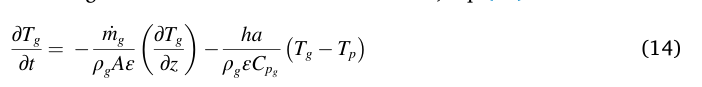

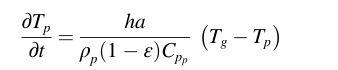

Carga, mediante aire caliente
aire:
$$
\frac{dT_g}{dt} = -\frac{\dot{m_g}}{\rho_g A\epsilon}\frac{dT_g}{dz} -\frac{ha}{\rho_g C_{p_{g}}\epsilon}(T_g-T_p)
$$
Lecho:
$$
\frac{dT_p}{dt} = \frac{ha}{\rho_p C_{p_{p}}(1-\epsilon)}(T_g-T_p)
$$

In [ ]:
air = PropsSI('D','T',300,'P',101325,'Air')  # Density of air at 300K and 1 atm

In [ ]:
def rho_air(T, P):
    return PropsSI('D', 'T', T, 'P', P, 'Air')
def cp_air(T, P):
    return PropsSI('C', 'T', T, 'P', P, 'Air')
def mu_air(T, P):
    return PropsSI('V', 'T', T, 'P', P, 'Air')
def k_air(T, P):
    return PropsSI('L', 'T', T, 'P', P, 'Air')  
def Pr_air(T, P):
    return cp_air(T, P) * mu_air(T, P) / k_air(T, P)
def nu_air(T, P):
    return mu_air(T, P) / rho_air(T, P)
def alpha_air(T, P):
    return k_air(T, P) / (rho_air(T, P) * cp_air(T, P))
def Re_air(V, L, T, P):
    return rho_air(T, P) * V * L / mu_air(T, P)
def Nu_air(Re, Pr):
    if Re < 2300:
        return 3.66  # Laminar flow in a pipe
    else:
        return 0.023 * Re**0.8 * Pr**0.3  # Turbulent flow in a pipe

def Nu_lecho(Re, Pr):
        return 3.22 * Re**0.33 * Pr**0.33 + 0.117 * Re**0.8 * Pr**0.4 # Turbulent flow over a flat plate
def epsilon(D,dp):
    return 0.4272 - 4.516e-3 * (dp / D) + 7.881e-5 * (dp / D)**2
def Re_lecho(dp,vf , T, P):
    return mu_air(T,P) * dp / vf
def h_lecho(dp, vf, T, P):
    Re = Re_lecho(dp, vf, T, P)
    Pr = Pr_air(T, P)
    Nu = Nu_lecho(Re, Pr)
    k = k_air(T, P)
    return Nu * k / dp



In [2]:
# parametros
L = 1  # m
Area = 1   # m2
h_air = 50  # W/m2K
h_water = 100  # W/m2K
a = 1  # m2/m3
rho_p = 2500  # kg/m3
Cp_p = 800  # J/kgK
epsilon = 0.4  # fraccion de vacios
m_g = 1  # kg/s
rho_g = 1.2  # kg/m3
Cp_g = 1005  # J/kgK
T_g_in = 600 # K
T_p0 = 300  # K

In [3]:
# nodos direccion Z
n = 20
# time step
dt = 1 # s

# grilla de z
z = np.linspace(0, L, n + 1 ) # m

# espaciamiento
dz = z[1] - z[0] # m
print(dz)
# condiciones iniciales
T_g0 = np.ones(n+1) # °C

# tiempo inicial
t0 = 0  # s
# tiempo final
tf = 1800  # s
# tiempo de evaluacion
t_eval = np.arange(t0, tf, dt)
# intervalo de tiempo
t_span = (t0, tf)

0.05


Aplicando diferencias finitas:

central:
$$
\frac{dT_g}{dz} = \frac{T_{g_{i+1}}-T_{g_{i-1}}}{2\Delta z}
$$

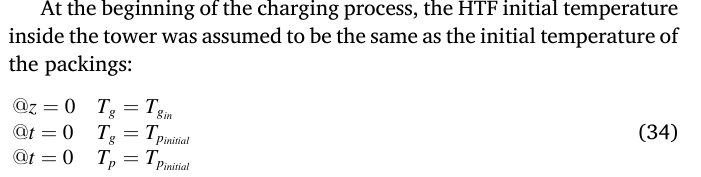

inicio

$$
T_{g_{1}}(0,t) = T_{g_{in}}
$$

$$
T_{g_{1}}(z,0) = T_{p_{in}}
$$

$$
T_{p_{1}}(z,0) = T_{p_{in}}
$$


backward:
$$
\frac{dT_g}{dz} = \frac{T_{g_{i}}-T_{g_{i-1}}}{\Delta z}
$$
$$
\frac{dT_{g_i}}{dt} = -\frac{\dot{m_g}}{\rho_g A\epsilon}\frac{T_{g_{i}}-T_{g_{i-1}}}{\Delta z} -\frac{ha}{\rho_g C_{p_{g}}\epsilon}(T_{g_i}-T_p)
$$

$$
\frac{dT_{g_i}}{dt} = \frac{\dot{m_g}}{\rho_g A\epsilon \Delta z}T_{g_{i-1}}-\left(\frac{ha}{\rho_g C_{p_{g}}\epsilon}+\frac{\dot{m_g}}{\rho_g A\epsilon \Delta z}\right) T_{g_i} +  \frac{ha}{\rho_g C_{p_{g}}\epsilon} T_p
$$

Lecho:
$$
\frac{dT_{p_i}}{dt} = \frac{ha}{\rho_p C_{p_{p}}(1-\epsilon)}(T_{g_i}-T_{p_i})
$$

$$
\frac{dT_{p_i}}{dt} = - \frac{ha}{\rho_p C_{p_{p}}(1-\epsilon)} T_{p_i} + \frac{ha}{\rho_p C_{p_{p}}(1-\epsilon)} T_{g_i} 
$$

In [4]:
# inicializacion de la matriz
Atg = np.zeros([n+1, n+1])
Atp = np.zeros([n+1, n+1])
# construccion de la matriz
for i in range(1, n+1):
    Atg[i][i-1] = m_g/(rho_g * Area * epsilon * dz)
    Atg[i][i] = - ((h_air * a)/(rho_g * Cp_g * epsilon) + (m_g/(rho_g * Area * epsilon * dz)))

for i in range(0, n+1):
    Atp[i][i] = - (h_air * a)/(rho_p * Cp_p * (1 - epsilon))


# CB dTg
def TES_carga(t,y, h_air, a, rho_p, Cp_p, rho_g, Cp_g, epsilon, m_g, Area, Atg, Atp):
    # Ecuación diferencial
    n = int(len(y)/2 - 1)
    T_p = y[0:(n+1)].copy()
    T_g = y[(n+1):].copy()

    btg = np.zeros(n+1)
    btp = np.zeros(n+1)

    for i in range(1, n+1):
        btg[i] =  (h_air * a)/(rho_g * Cp_g * epsilon) * T_p[i]

    for i in range(1, n+1):
        btp[i] = (h_air * a)/(rho_p * Cp_p * (1 - epsilon)) * T_g[i]
    #b[0] = T_g_in
    dT_gdt = np.dot(Atg, T_g) + btg
    dT_pdt = np.dot(Atp, T_p) + btp
    dy = np.empty_like(y)
    dy[0:(n+1)] = dT_pdt
    dy[(n+1):] = dT_gdt
    return dy
T_p0 = np.ones(n+1) * T_p0
T_g0 = np.ones(n+1) * T_p0
T_g0[0] = T_g_in
y0 = np.concatenate([T_p0, T_g0])
sol = solve_ivp(TES_carga, t_span, y0, method="BDF", t_eval=t_eval, atol=1e-6, rtol=1e-6, args=(h_air, a, rho_p, Cp_p, rho_g, Cp_g, epsilon, m_g, Area, Atg, Atp))

In [5]:
sol.y.shape
T_g_sol = sol.y[n+1:, :]
T_p_sol = sol.y[0:n+1, :]
tiempo1 = sol.t

1800


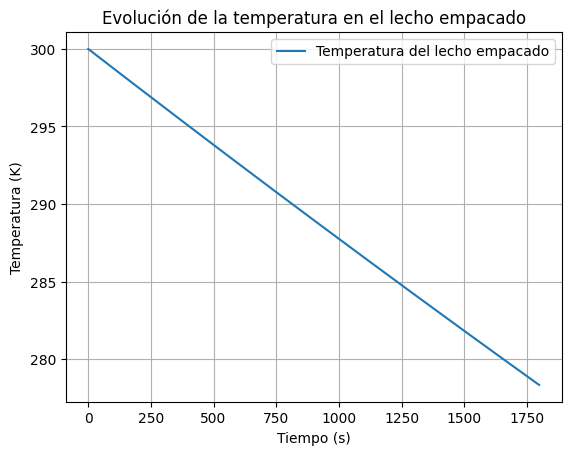

In [6]:
tiempo1 = sol.t
print(len(tiempo1))
T1 = sol.y[0]
# Gráficas
plt.plot(tiempo1, T1, label='Temperatura del lecho empacado')
plt.xlabel('Tiempo (s)')
plt.ylabel('Temperatura (K)')
plt.title('Evolución de la temperatura en el lecho empacado')
plt.legend()
plt.grid()
plt.show()  

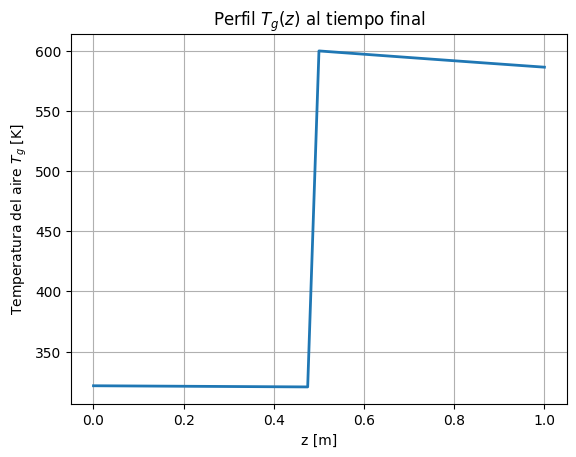

In [46]:
# Extrae la matriz de temperaturas del gas (n_g nodos x Nt instantes)
Tg_t = sol.y[1:, :]            # y = [T_p, T_g(0..n_g-1)]
n_g, Nt = Tg_t.shape

# Vector espacial z
try:
    L  # usa L si existe en tu entorno
except NameError:
    L = 1.0
z = np.linspace(0.0, L, n_g)

# Elige el perfil a graficar: aquí el tiempo final
Tg_final = Tg_t[:, -1]

plt.figure()
plt.plot(z, Tg_final, linewidth=2)
plt.xlabel('z [m]')
plt.ylabel('Temperatura del aire $T_g$ [K]')
plt.title('Perfil $T_g(z)$ al tiempo final')
plt.grid(True)
plt.show()

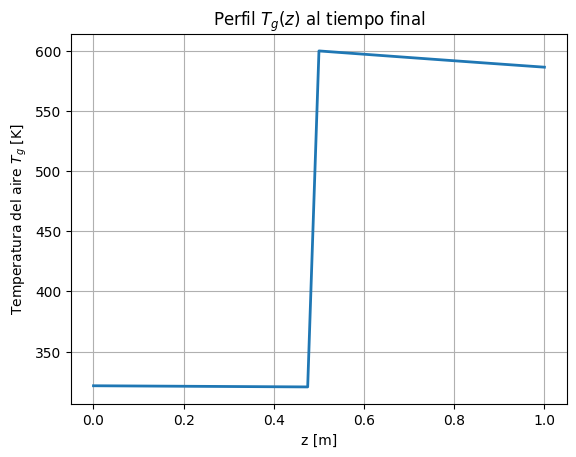

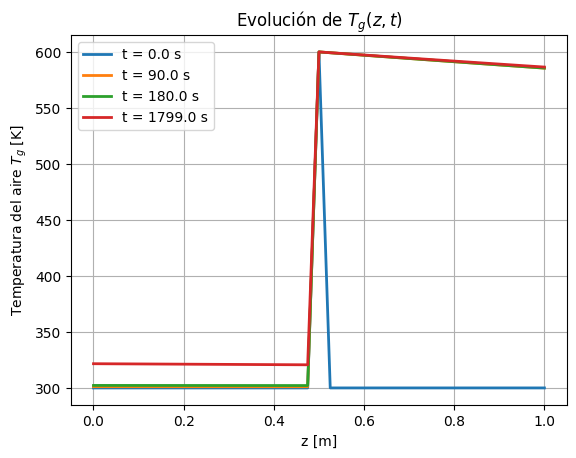

In [47]:
Tg_t = sol.y[1:, :]           # (n_g, Nt)
n_g, Nt = Tg_t.shape

# Mallado espacial
L = 1.0  # cambia si tu lecho tiene otro largo
z = np.linspace(0.0, L, n_g)

# ----- 1) Línea: perfil al tiempo final -----
plt.figure()
plt.plot(z, Tg_t[:, -1], linewidth=2)
plt.xlabel('z [m]')
plt.ylabel('Temperatura del aire $T_g$ [K]')
plt.title('Perfil $T_g(z)$ al tiempo final')
plt.grid(True)
plt.show()

# ----- 2) Varias líneas (evolución en el tiempo) -----
idxs = [0, max(1, Nt//20), max(1, Nt//10), Nt-1]  # inicio, 12%, 25%, final
plt.figure()
for k in idxs:
    plt.plot(z, Tg_t[:, k], linewidth=2, label=f't = {sol.t[k]:.1f} s')
plt.xlabel('z [m]')
plt.ylabel('Temperatura del aire $T_g$ [K]')
plt.title('Evolución de $T_g(z,t)$')
plt.legend()
plt.grid(True)
plt.show()


#### HASTA AQUI


def TES_carga(t,y, h_air, a, rho_p, Cp_p, rho_g, Cp_g, epsilon, m_g, A):
    # Ecuación diferencial
    T_p = y[0]
    T_g = y[1]
    dT_gdt = -m_g/(rho_g*A*epsilon) - (h_air*a/(rho_g*Cp_g*epsilon))*(T_g - T_p)
    dT_pdt = (h_air*a/(rho_p*Cp_p*(1-epsilon)))*(T_g - T_p)
    return [dT_pdt]